Part B : Sentiment Analysis & Hybrid Model

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', None)
import yfinance as yf
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
#Importing the news Headlines Data
news_data=pd.read_csv('india-news-headlines.csv')

In [4]:
news_data.shape

(3297172, 3)

In [5]:
news_data.head(30)

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating undertaker bigger roman reigns
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; says Vajpayee
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa
5,20010102,unknown,Extra buses to clear tourist traffic
6,20010102,unknown,Dilute the power of transfers; says Riberio
7,20010102,unknown,Focus shifts to teaching of Hindi
8,20010102,unknown,IT will become compulsory in schools
9,20010102,unknown,Move to stop freedom fighters' pension flayed


In [6]:
news_data.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

In [7]:
#Converting to publish_date from string date format
news_data['publish_date'] = pd.to_datetime(news_data.publish_date,format='%Y%m%d')

In [8]:
#Defining function for cleaning the headlines text
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()
def NewsHeadlinesPreprocessing(headline):
    temp=re.sub(r"http\S+","",headline) #removes hyperlinks
    temp=re.sub(r"[^a-zA-Z0-9]$","",temp) #subtitute special charaters in the end with nothing
    temp=re.sub(r"[^a-zA-Z0-9]"," ",temp) #subtitute special charaters in the middle with space
    temp=re.sub(' {2,}', ' ',temp) #subtitiute more than two spaces with a single space
    temp=temp.lower() # convert all text to lowercase
    tokens=[w for w in temp.split() if  w not in stopwords] #stopwords removal
    finalString=''
    for i in tokens:
        lemmatized_string=lemmatizer.lemmatize(i) #lemmatisation for reducing each token to its lemma/root form
        if(len(lemmatized_string)>2):
            finalString=finalString+lemmatized_string+' '
    return finalString

In [9]:
#Creating a seperate column for cleaned headline data
clean_headline_text=[]
for i in news_data['headline_text']:
    clean_headline_text.append(NewsHeadlinesPreprocessing(i))
news_data['clean_headline_text']=clean_headline_text    

As Next step, we will use NLTK’s built-in Vader Sentiment Analyzer which will simply rank a piece of text as positive, negative or neutral using a lexicon of positive and negative words.

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [11]:
sia = SIA()
Sentiment_Results = []
for news in news_data['clean_headline_text']:
    Sentiment_Results.append(sia.polarity_scores(news))
Sentiment_Results=pd.DataFrame(Sentiment_Results)
Processed_NewsData=pd.concat([news_data, Sentiment_Results], axis=1)

In [13]:
#Aggregating sentiment values which occoured on same date
Aggregate_NewsData=Processed_NewsData.groupby('publish_date')[['neg','neu','pos','compound']].agg('sum').reset_index()
Aggregate_count=pd.DataFrame(Processed_NewsData["publish_date"].value_counts().reset_index())
Aggregate_count.columns = ['publish_date', 'count']
Aggregate_NewsData.columns =['publish_date','Total Negative','Total Neutral','Total Positive','Total Compound']
Aggregate_NewsData=pd.merge(Aggregate_NewsData,Aggregate_count,on='publish_date',how='left')

In [17]:
#Extracting Sensex data for the given period of news headlines
Sensex_Data =yf.download("^BSESN", start = '2001-01-01', end='2020-06-30')

[*********************100%***********************]  1 of 1 completed


In [12]:
Sensex_Data.shape

(4794, 6)

In [19]:
Sensex_Data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,3953.219971,4028.570068,3929.370117,4018.879883,4018.879883,0
2001-01-03,3977.580078,4067.659912,3977.580078,4060.020020,4060.020020,0
2001-01-04,4180.970215,4180.970215,4109.549805,4115.370117,4115.370117,0
2001-01-05,4116.339844,4195.009766,4115.350098,4183.729980,4183.729980,0
2001-01-08,4164.759766,4206.720215,4101.529785,4120.430176,4120.430176,0


In [20]:
#Reseting index
Sensex_Data.reset_index(level=0, inplace=True)

In [21]:
#Aggregating Sensex data and News Data through left join
X=pd.merge(Sensex_Data[['Date','Adj Close']], Aggregate_NewsData, how='left', left_on='Date', right_on='publish_date')
del X['publish_date']

In [22]:
X.isnull().sum()

Date               0
Adj Close          0
Total Negative    28
Total Neutral     28
Total Positive    28
Total Compound    28
count             28
dtype: int64

In [23]:
X.shape

(4794, 7)

In [24]:
#Dropping the 28 NA values from data
X.dropna(subset=['count'],inplace=True)

In [25]:
#Checking the datatype
X.dtypes

Date              datetime64[ns]
Adj Close                float64
Total Negative           float64
Total Neutral            float64
Total Positive           float64
Total Compound           float64
count                    float64
dtype: object

In [26]:
#Converting count to int datatype
X['count']= X['count'].apply(np.int64)

In [27]:
X.dtypes

Date              datetime64[ns]
Adj Close                float64
Total Negative           float64
Total Neutral            float64
Total Positive           float64
Total Compound           float64
count                      int64
dtype: object

In [28]:
X.head(5)

,Date,Adj Close,Total Negative,Total Neutral,Total Positive,Total Compound,count
0,2001-01-02,4018.879883,9.882,68.581,7.537,-1.6075,86
1,2001-01-03,4060.020020,5.184,30.812,5.003,-0.8553,41
2,2001-01-04,4115.370117,14.442,123.130,15.428,2.0083,153
3,2001-01-05,4183.729980,17.434,86.952,21.614,2.7493,126
4,2001-01-08,4120.430176,6.533,52.531,6.936,-2.3840,66


Univariate & Bivariate Analysis before Model creation 

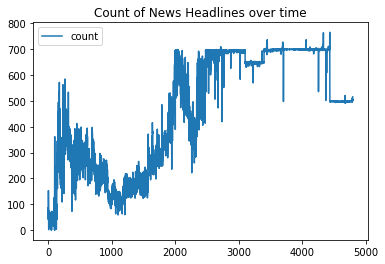

In [29]:
#Plotting different components over time 
X[['count']].plot()
plt.title("Count of News Headlines over time")
plt.show()

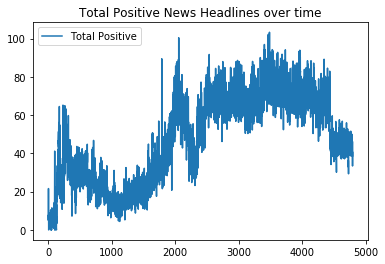

In [30]:
X[['Total Positive']].plot()
plt.title("Total Positive News Headlines over time")
plt.show()

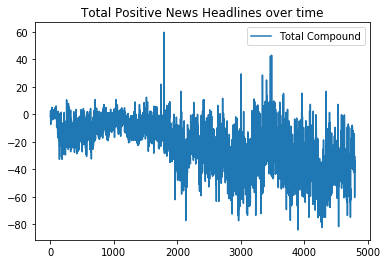

In [31]:
X[['Total Compound']].plot()
plt.title("Total Positive News Headlines over time")
plt.show()

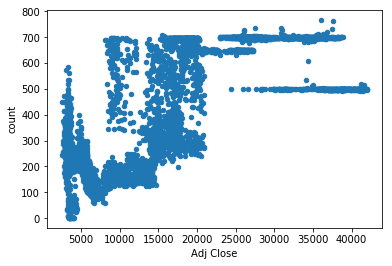

In [32]:
X.plot.scatter('Adj Close','count')

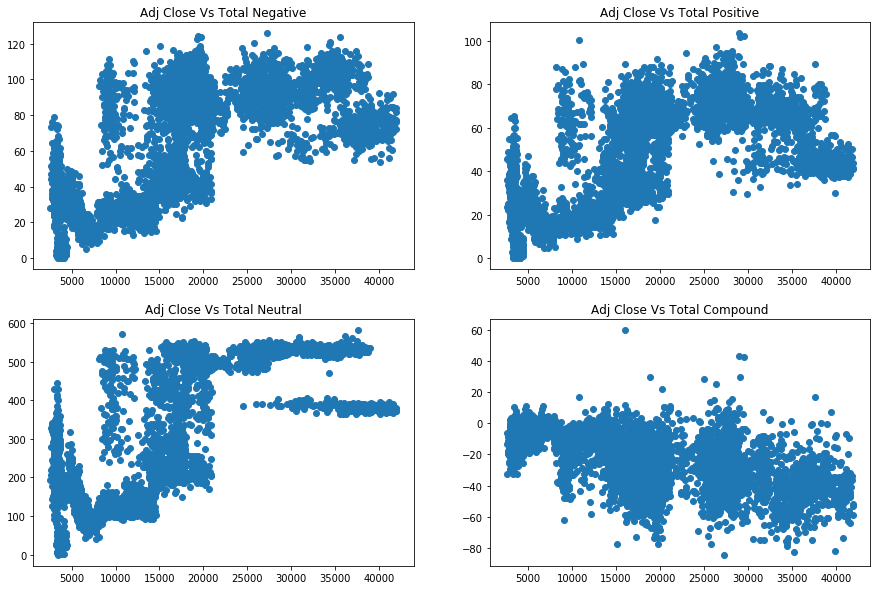

In [75]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2,figsize=(15,10))


ax[0, 0].scatter(X['Adj Close'],X['Total Negative'])
ax[1, 0].scatter(X['Adj Close'],X['Total Neutral'])
ax[0, 1].scatter(X['Adj Close'],X['Total Positive'])
ax[1, 1].scatter(X['Adj Close'],X['Total Compound'])
ax[0, 0].set_title('Adj Close Vs Total Negative')
ax[1, 0].set_title('Adj Close Vs Total Neutral')
ax[0, 1].set_title('Adj Close Vs Total Positive')
ax[1, 1].set_title('Adj Close Vs Total Compound')

plt.show()

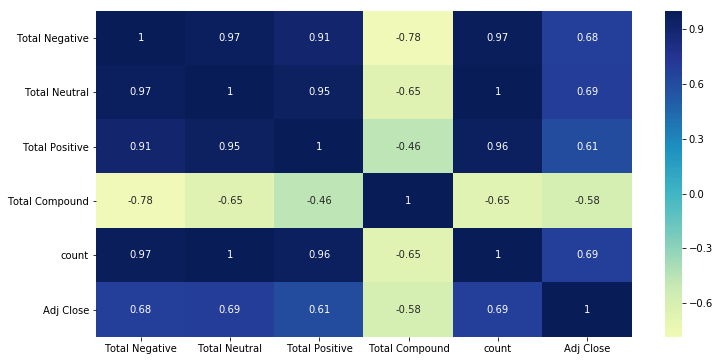

In [33]:
Numerical_Columns=['Total Negative','Total Neutral','Total Positive','Total Compound','count','Adj Close']
plt.figure(figsize=(12, 6))
sns.heatmap(X[Numerical_Columns].corr(), annot = True, center=0, cmap="YlGnBu")

'Total Neutral' is highly correlated (>.90) with 'Total Negative' 'Count' & 'Total Postive' . Hence we can just take 'Total Neutral' attribute in our model building

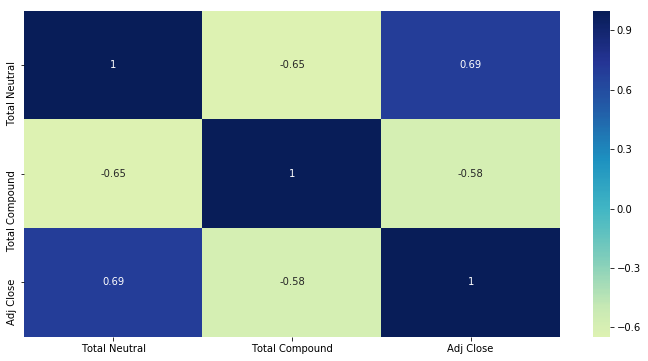

In [34]:
Numerical_Columns=['Total Neutral','Total Compound','Adj Close']
plt.figure(figsize=(12, 6))
sns.heatmap(X[Numerical_Columns].corr(), annot = True, center=0, cmap="YlGnBu")

Based on Univariate & Bivariate Analysis, Final Model will have the following independent variables 'Total Neutral' & 'Total Compound'

In [111]:
#Split into Train and test data
x_train, x_test = X[0:int(len(Sensex_Data)*0.8)][['Total Neutral','Total Compound']], X[int(len(Sensex_Data)*0.8)+1:][['Total Neutral','Total Compound']]
y_train, y_test = X[0:int(len(Sensex_Data)*0.8)][['Adj Close']], X[int(len(Sensex_Data)*0.8)+1:][['Adj Close']]

In [112]:
x_train.shape,x_test.shape,y_train.shape, y_test.shape

((3835, 2), (930, 2), (3835, 1), (930, 1))

In [113]:
#Scaling the train data for LinearRegression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Cols=x_train.columns
x_train_scaled=scaler.fit_transform(x_train)
x_train_scaled=pd.DataFrame(x_train_scaled,columns=Cols)
x_train_scaled.head(5)

,Total Neutral,Total Compound
0,0.120148,0.552924
1,0.053980,0.558408
2,0.215713,0.579286
3,0.152332,0.584688
4,0.092030,0.547263


In [114]:
x_test_scaled=scaler.fit_transform(x_test)
x_test_scaled=pd.DataFrame(x_test_scaled,columns=Cols)
x_test_scaled.head(5)

,Total Neutral,Total Compound
0,0.720830,0.609042
1,0.730202,0.539740
2,0.796328,0.639907
3,0.746981,0.388650
4,0.679836,0.536815


In [39]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.metrics import mean_squared_error

In [40]:
#Building baseline LinearRegression model
ModelLR=LR()
ModelLR.fit(x_train_scaled, y_train)
preds_val = ModelLR.predict(x_test_scaled)
np.sqrt(mean_squared_error(y_test, preds_val))

23827.824867528885

C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


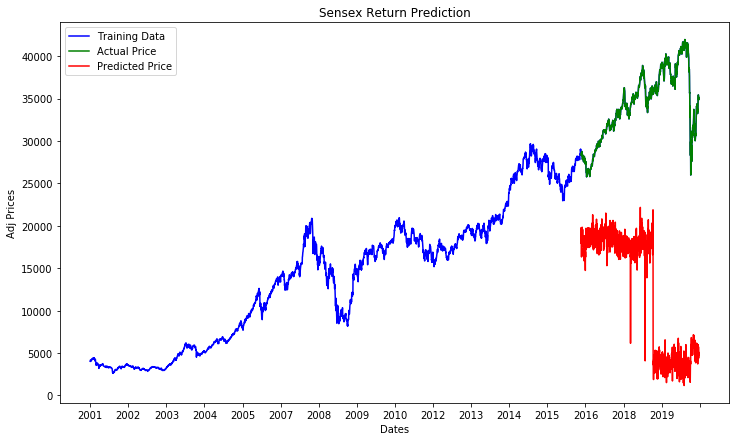

In [41]:
#Plotting the predicted values from baseline LinearRegression model
plt.figure(figsize=(12,7))
plt.plot(X['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(x_test.index[:],y_test, color='green', label='Actual Price')
plt.plot(x_test.index[:], preds_val, color='red', label='Predicted Price')
plt.title('Sensex Return Prediction:Baseline LinearRegression model')
plt.xlabel('Dates')
plt.ylabel('Adj Prices')
plt.xticks(np.arange(0,4838,300), X['Date'].dt.year[0:4838:300])
plt.legend()

In [42]:
from sklearn.tree import DecisionTreeRegressor as DTR

In [43]:
#Building a baseline DecisionTreeRegressor model
ModelDTR=DTR()
ModelDTR.fit(x_train, y_train)
preds_val = ModelLR.predict(x_test)
np.sqrt(mean_squared_error(y_test, preds_val))

9826231.865996221

In [44]:
#Searching for best DecisionTreeRegressor model parameters using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [2, 10, 20, 30, 40],
              "max_depth": [4, 6, 8, 10, 12],
              "min_samples_leaf": [8, 16, 32, 64, 128],
              "max_leaf_nodes": [8, 16, 32, 64, 128],
              }
preds_val = RandomizedSearchCV(DTR(),
                         param_grid,
                         scoring='neg_mean_squared_error',
                         n_iter=90)

search = preds_val.fit(x_train, y_train)

search.best_params_

{'min_samples_split': 30,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 16,
 'max_depth': 12,
 'criterion': 'mse'}

In [47]:
#Constructing the optimal DecisionTreeRegressor model
optimal_params = {'min_samples_split': 30,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 16,
 'max_depth': 12,
 'criterion': 'mse'}
ModelDTRBest=DTR(**optimal_params)
ModelDTRBest.fit(x_train, y_train)
preds_val = ModelDTRBest.predict(x_test)
np.sqrt(mean_squared_error(y_test, preds_val))

16193.057332152484

C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\Ankit Thakur\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


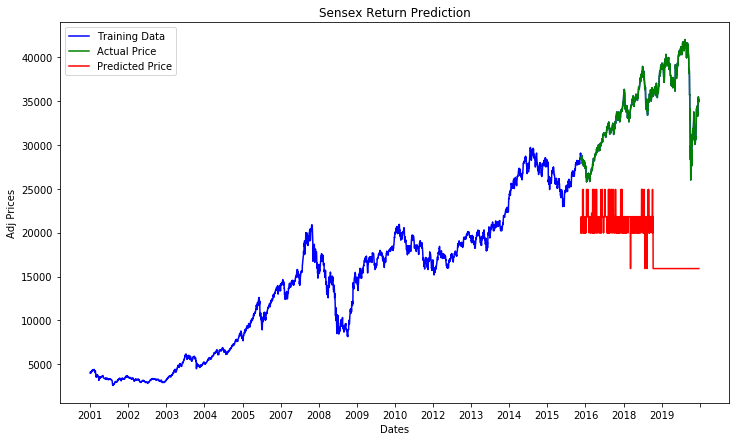

In [48]:
#Plotting the Optimal DecisionTreeRegressor model
plt.figure(figsize=(12,7))
plt.plot(X['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(x_test.index[:],y_test, color='green', label='Actual Price')
plt.plot(x_test.index[:], preds_val, color='red', label='Predicted Price')
plt.title('Sensex Return Prediction:Optimal DecisionTreeRegressor model')
plt.xlabel('Dates')
plt.ylabel('Adj Prices')
plt.xticks(np.arange(0,4838,300), X['Date'].dt.year[0:4838:300])
plt.legend()

In [49]:
#Importing Stock Market predictions from ARIMA Model
ArimaPrediction=pd.read_csv('ArimaPrediction.csv')
ArimaPrediction.rename(columns={'Unnamed: 0': 'Index'},inplace=True)

In [50]:
ArimaPrediction.dtypes

Index                 int64
ARIMA_Prediction    float64
dtype: object

In [51]:
ArimaPrediction.set_index('Index',inplace=True)

In [52]:
ArimaPrediction.head(5)

,ARIMA_Prediction
Index,
3836,28078.987609
3837,28077.617311
3838,28092.483197
3839,28082.404112
3840,28114.724667


Creating a Hybrid_Prediction DataFrame which will contain predictions from ARIMA (Time - Series) and DecisionTreeRegressor (Sentiment Analysis)

In [53]:
Hybrid_Prediction=pd.DataFrame(y_test)
Hybrid_Prediction.rename(columns={'Adj Close': 'Y_Test'},inplace=True)

In [54]:
y_test.shape,preds_val.shape

((930, 1), (930,))

In [55]:
Hybrid_Prediction['DTPrediction']=preds_val
Hybrid_Prediction=Hybrid_Prediction.join(ArimaPrediction['ARIMA_Prediction'])
Hybrid_Prediction.head(5)

In [72]:
def FinalPrediction(ratio,Hybrid_Prediction):
    PredFinal=ratio*Hybrid_Prediction['ARIMA_Prediction']+(1-ratio)*Hybrid_Prediction['DTPrediction']
    return PredFinal

Implementing Basic Ensemble Technique , giving more weigtage to ARIMA and less to DecisionTreeRegressor based on thier RMSE scores 

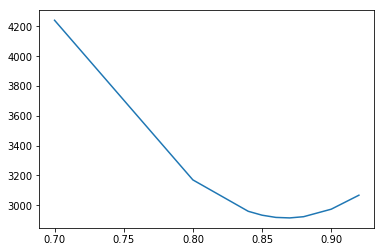

In [95]:
ratio_list=[.70,.80,.84,.85,.86,.87,.88,.90,.92]
list=[]
for ratio in ratio_list:
    PredFinal=FinalPrediction(ratio,Hybrid_Prediction)
    list.append(np.sqrt(mean_squared_error(y_test,PredFinal)))
plt.plot(ratio_list,list)
plt.show()

As we can observe from figure above, mean_squared_error for the hybrid model is attains minima at around 0.87

In [96]:
#Implenting Final Hybrid model
PredFinal=FinalPrediction(0.87,Hybrid_Prediction)
print(np.sqrt(mean_squared_error(y_test,PredFinal)))

2914.5854336468624


In [104]:
#Final Hybrid model mean absolute error
print(mean_absolute_error(y_test,PredFinal))

1936.134224106538


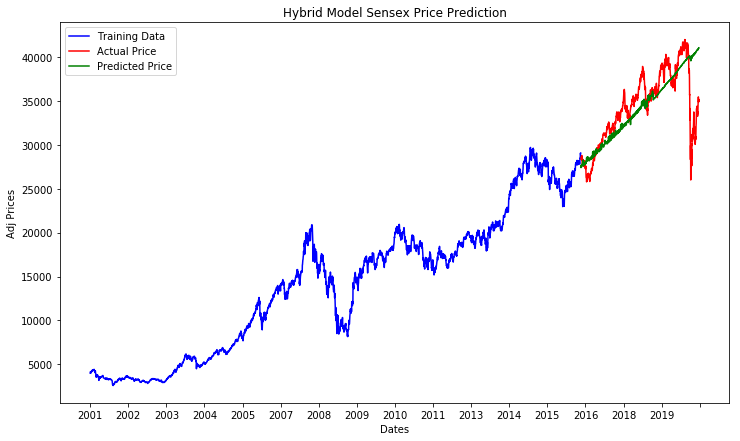

In [105]:
#Plotting the final Hybrid Model
plt.figure(figsize=(12,7))
plt.plot(y_train, 'green', color='blue', label='Training Data')
plt.plot(y_test.index[:],y_test, color='red', label='Actual Price')
plt.plot(y_test.index[:], PredFinal, color='green', label='Predicted Price')
plt.title('Sensex Return Prediction:Final Hybrid model')
plt.xlabel('Dates')
plt.ylabel('Adj Prices')
plt.xticks(np.arange(0,4838,300), Sensex_Data['Date'].dt.year[0:4838:300])
plt.legend()